In [2]:
from prophet import Prophet
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [22]:
df = pd.read_csv(r'..\..\data\processed\Merch_ML.csv',index_col='Order_ID')
df.head()

,Order_Date,Buyer_Age,Sales_Price,Shipping_Charges,Sales_per_Unit,Quantity,Total_Sales,Rating,Product_ID,Order_Location,International_Shipping,Buyer_Gender,Product_Category_Clothing,Product_Category_Ornaments,Product_Category_Other
Order_ID,,,,,,,,,,,,,,,
189440,2024-07-21,30,100,0,100,1,100,4,0,15,0,1,1.0,0.0,0.0
187385,2024-07-20,32,100,0,100,1,100,3,0,6,0,1,1.0,0.0,0.0
181844,2024-07-21,26,9,40,49,1,49,2,1,1,1,0,0.0,0.0,1.0
197934,2024-08-19,28,9,0,9,2,18,3,1,18,0,1,0.0,0.0,1.0
122470,2024-01-06,19,10,0,10,3,30,5,2,11,0,0,0.0,0.0,1.0


In [23]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])  # Convertir a datetime
df = df.sort_values(by=['Product_ID', 'Order_Date']).reset_index(drop=True)  # Ordenar fechas


In [24]:
df.drop(df[(df['Order_Date'].dt.month == 11) & (df['Order_Date'].dt.year == 2024)].index,axis=0,inplace=True)

In [32]:
df['Year_Month'] = df['Order_Date'].dt.to_period('M')  # Ejemplo: 2023-11

# Agrupar por mes y sumar las ventas
df_monthly_sales = df.groupby(['Product_ID', 'Year_Month'])['Total_Sales'].sum().reset_index()

# Convertir 'Year_Month' de Period a datetime (si es necesario)
df_monthly_sales['Year_Month'] = df_monthly_sales['Year_Month'].dt.to_timestamp()

df_monthly_sales[['Product_ID', 'Total_Sales']].head(12)

,Product_ID,Total_Sales
0,0,9960
1,0,13030
2,0,11690
3,0,13105
4,0,12770
5,0,14210
6,0,13385
7,0,10375
8,0,13835
9,0,9220


10:04:16 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing


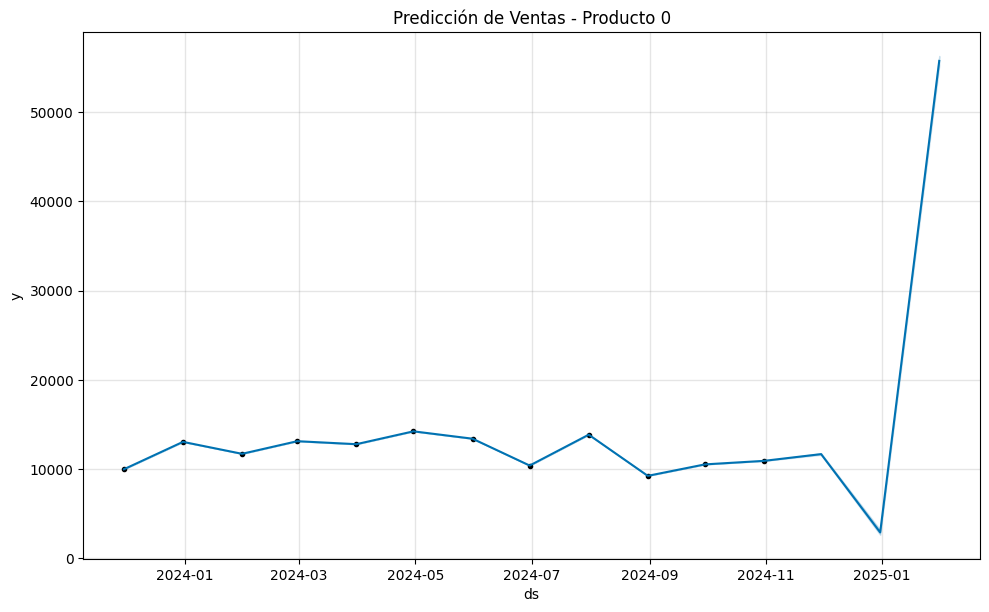

10:04:39 - cmdstanpy - INFO - Chain [1] start processing



Producto 0 - Predicciones mensuales corregidas para los próximos 3 meses:
           ds          yhat
12 2024-11-30  11655.953877
13 2024-12-31   2879.536595
14 2025-01-31  55745.611408


10:05:03 - cmdstanpy - INFO - Chain [1] done processing


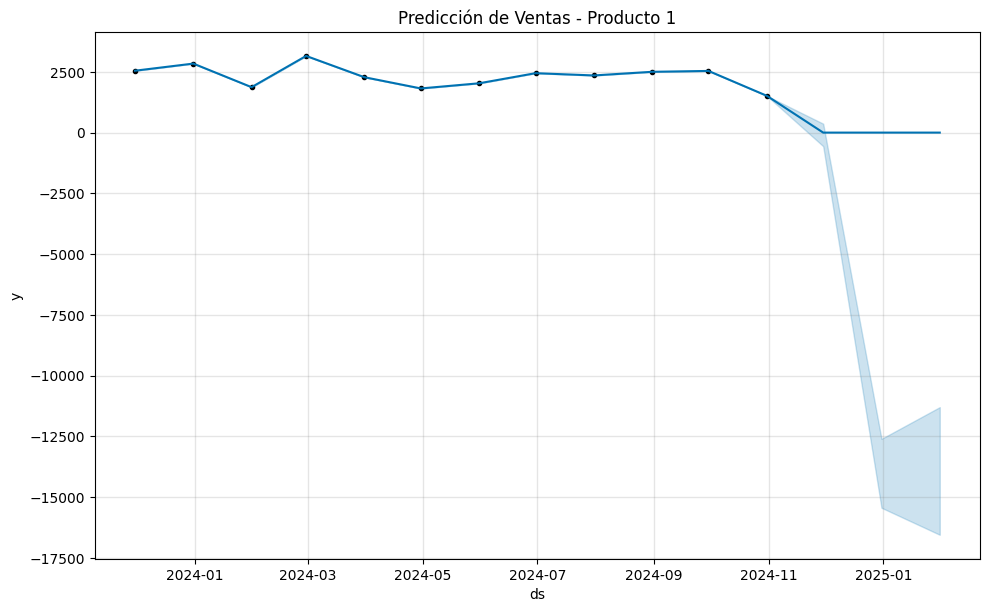

10:05:04 - cmdstanpy - INFO - Chain [1] start processing



Producto 1 - Predicciones mensuales corregidas para los próximos 3 meses:
           ds  yhat
12 2024-11-30   0.0
13 2024-12-31   0.0
14 2025-01-31   0.0


10:05:29 - cmdstanpy - INFO - Chain [1] done processing


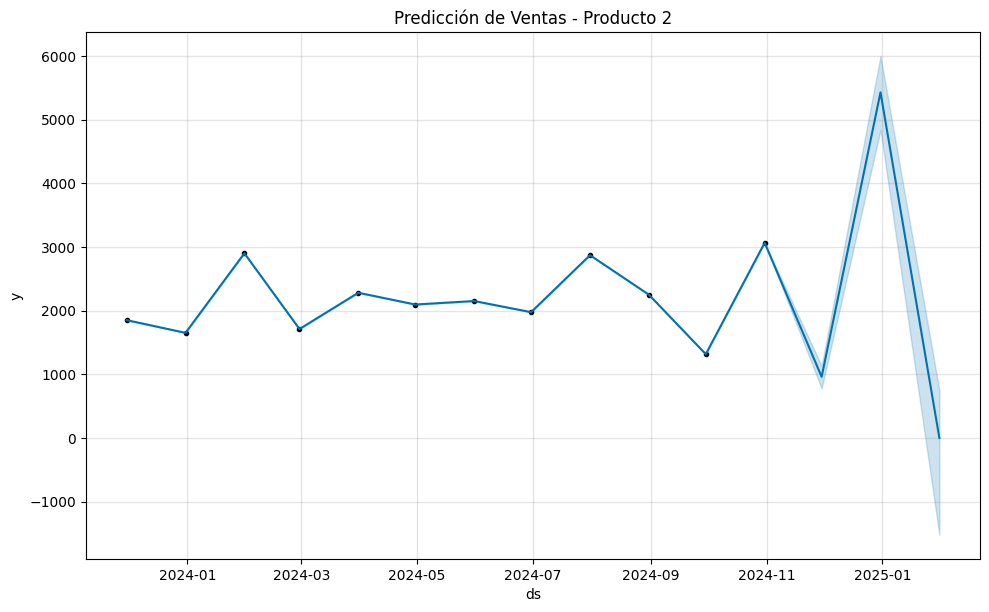

10:05:29 - cmdstanpy - INFO - Chain [1] start processing



Producto 2 - Predicciones mensuales corregidas para los próximos 3 meses:
           ds         yhat
12 2024-11-30   959.310323
13 2024-12-31  5428.610309
14 2025-01-31     0.000000


10:05:53 - cmdstanpy - INFO - Chain [1] done processing


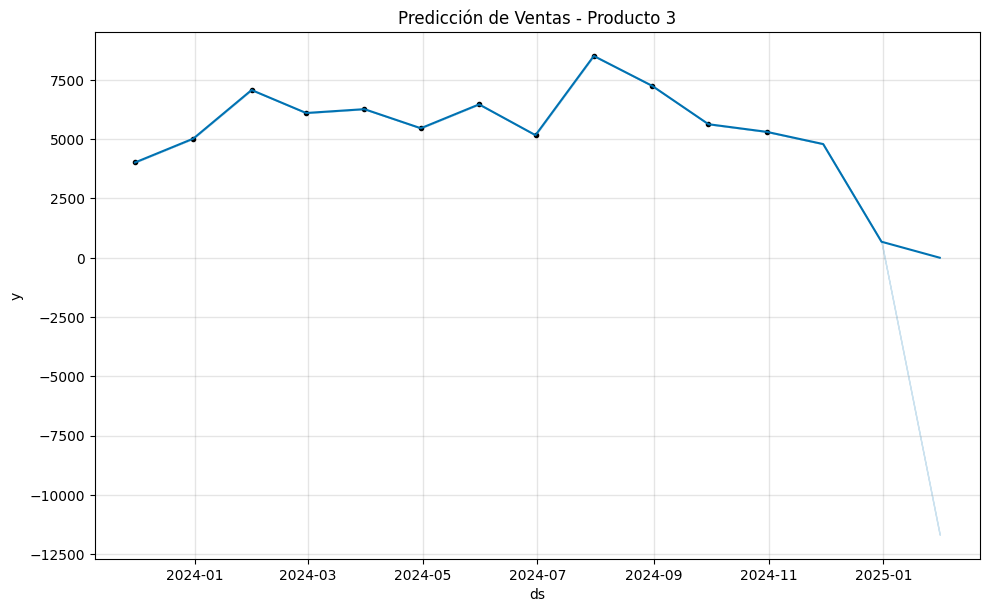

10:05:53 - cmdstanpy - INFO - Chain [1] start processing



Producto 3 - Predicciones mensuales corregidas para los próximos 3 meses:
           ds         yhat
12 2024-11-30  4791.816440
13 2024-12-31   675.169501
14 2025-01-31     0.000000


10:06:17 - cmdstanpy - INFO - Chain [1] done processing


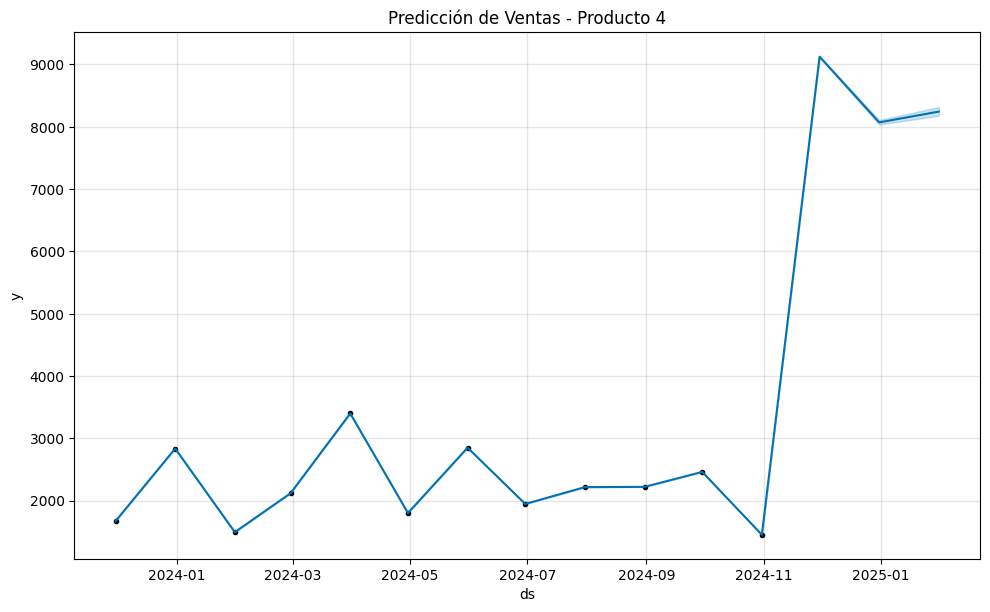

10:06:17 - cmdstanpy - INFO - Chain [1] start processing



Producto 4 - Predicciones mensuales corregidas para los próximos 3 meses:
           ds         yhat
12 2024-11-30  9125.726889
13 2024-12-31  8070.559955
14 2025-01-31  8243.946888


10:06:40 - cmdstanpy - INFO - Chain [1] done processing


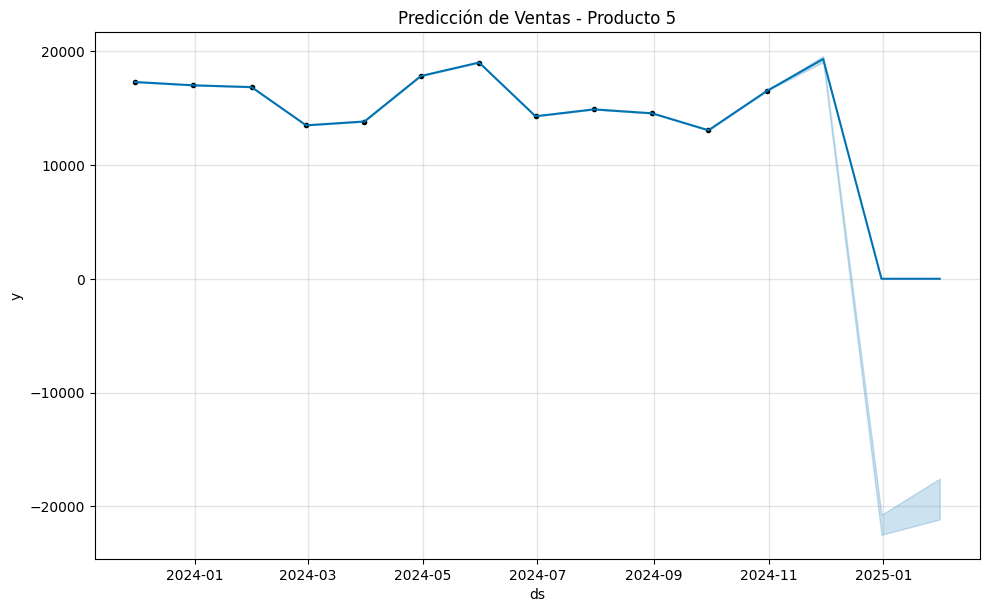

10:06:41 - cmdstanpy - INFO - Chain [1] start processing



Producto 5 - Predicciones mensuales corregidas para los próximos 3 meses:
           ds          yhat
12 2024-11-30  19303.443317
13 2024-12-31      0.000000
14 2025-01-31      0.000000


10:07:04 - cmdstanpy - INFO - Chain [1] done processing


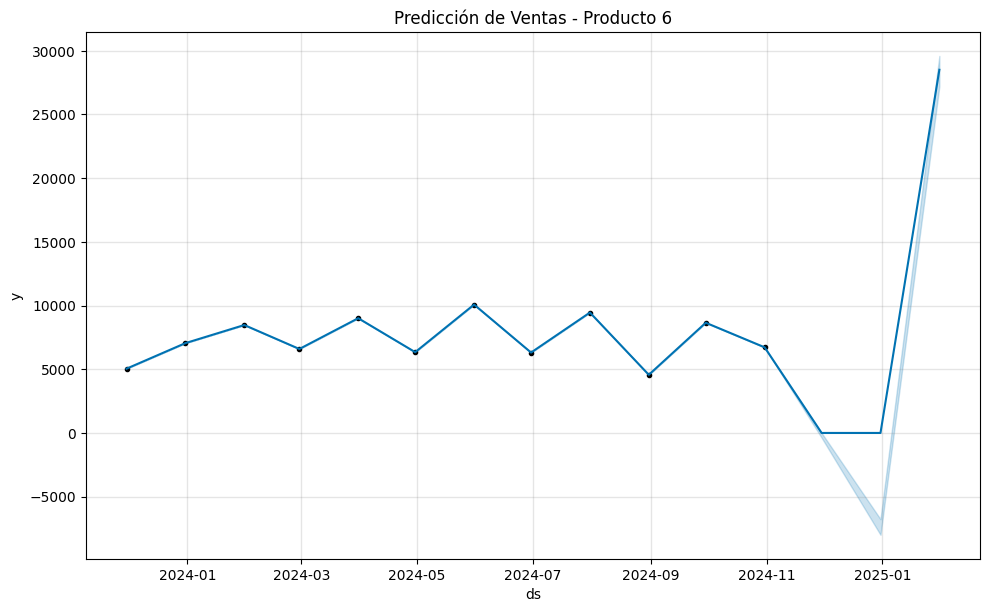

10:07:04 - cmdstanpy - INFO - Chain [1] start processing



Producto 6 - Predicciones mensuales corregidas para los próximos 3 meses:
           ds          yhat
12 2024-11-30      0.000000
13 2024-12-31      0.000000
14 2025-01-31  28505.714888


10:07:28 - cmdstanpy - INFO - Chain [1] done processing


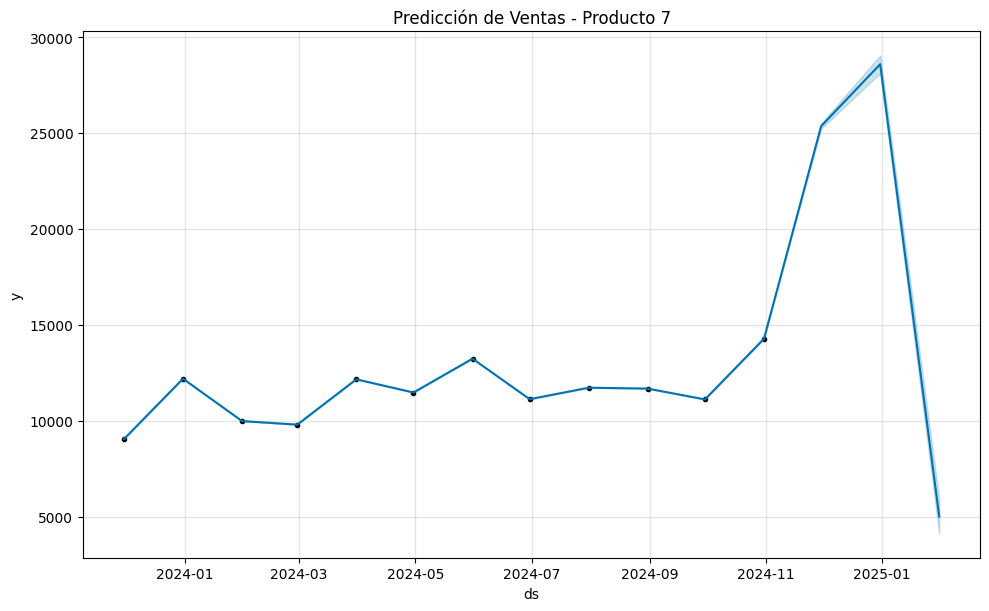

10:07:28 - cmdstanpy - INFO - Chain [1] start processing



Producto 7 - Predicciones mensuales corregidas para los próximos 3 meses:
           ds          yhat
12 2024-11-30  25359.642368
13 2024-12-31  28592.200234
14 2025-01-31   5006.319389


10:07:53 - cmdstanpy - INFO - Chain [1] done processing


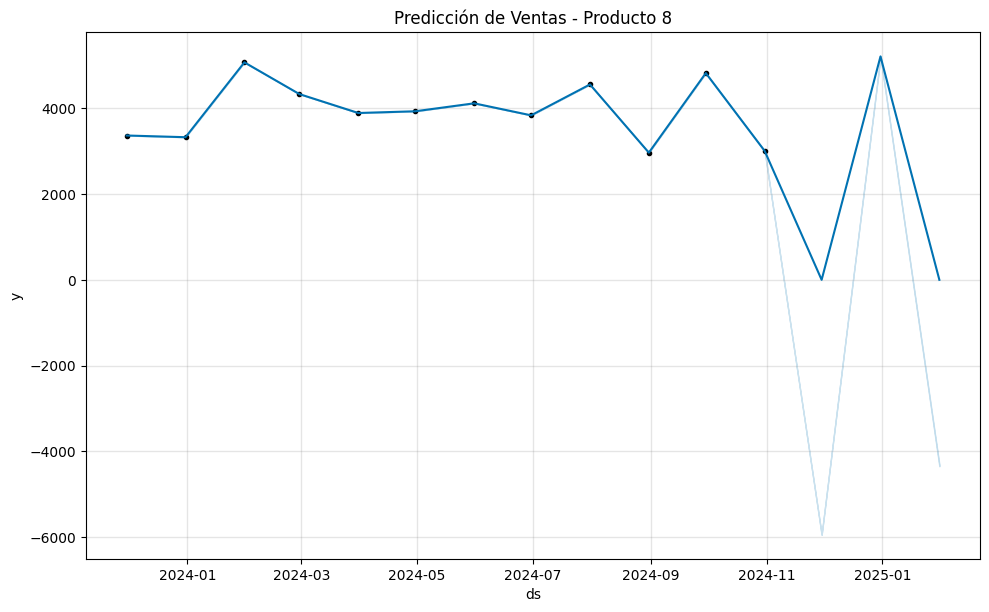

10:07:53 - cmdstanpy - INFO - Chain [1] start processing



Producto 8 - Predicciones mensuales corregidas para los próximos 3 meses:
           ds         yhat
12 2024-11-30     0.000000
13 2024-12-31  5208.963638
14 2025-01-31     0.000000


10:08:17 - cmdstanpy - INFO - Chain [1] done processing


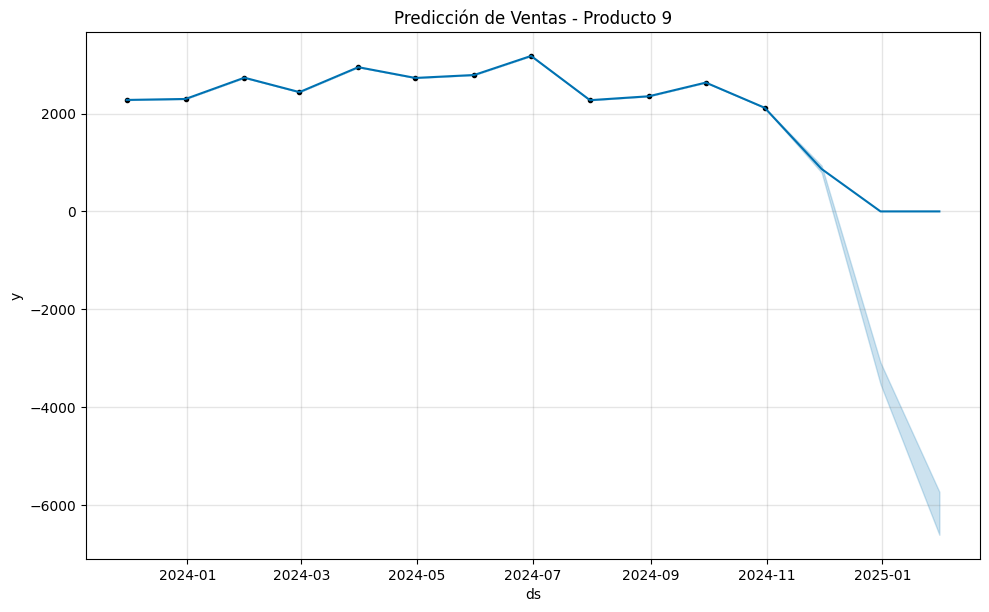

10:08:18 - cmdstanpy - INFO - Chain [1] start processing



Producto 9 - Predicciones mensuales corregidas para los próximos 3 meses:
           ds        yhat
12 2024-11-30  867.330306
13 2024-12-31    0.000000
14 2025-01-31    0.000000


10:08:42 - cmdstanpy - INFO - Chain [1] done processing


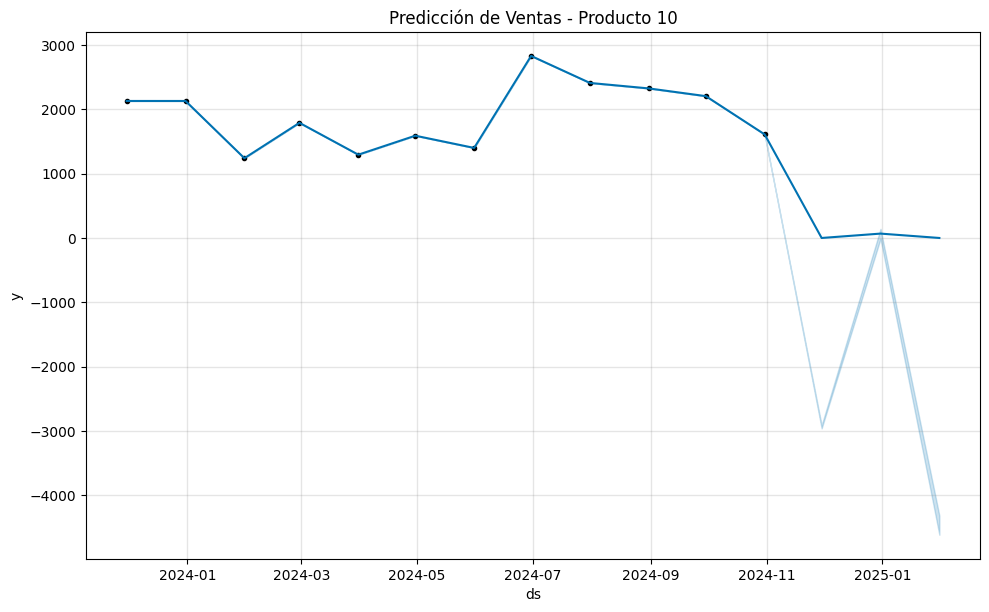

10:08:43 - cmdstanpy - INFO - Chain [1] start processing



Producto 10 - Predicciones mensuales corregidas para los próximos 3 meses:
           ds       yhat
12 2024-11-30   0.000000
13 2024-12-31  67.971389
14 2025-01-31   0.000000


10:09:07 - cmdstanpy - INFO - Chain [1] done processing


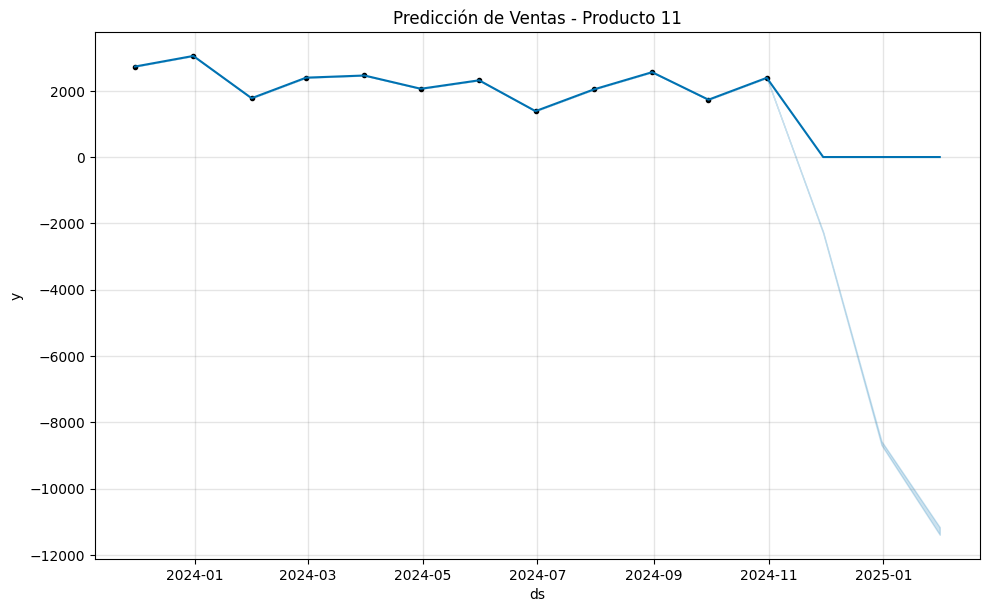

10:09:07 - cmdstanpy - INFO - Chain [1] start processing



Producto 11 - Predicciones mensuales corregidas para los próximos 3 meses:
           ds  yhat
12 2024-11-30   0.0
13 2024-12-31   0.0
14 2025-01-31   0.0


10:09:32 - cmdstanpy - INFO - Chain [1] done processing


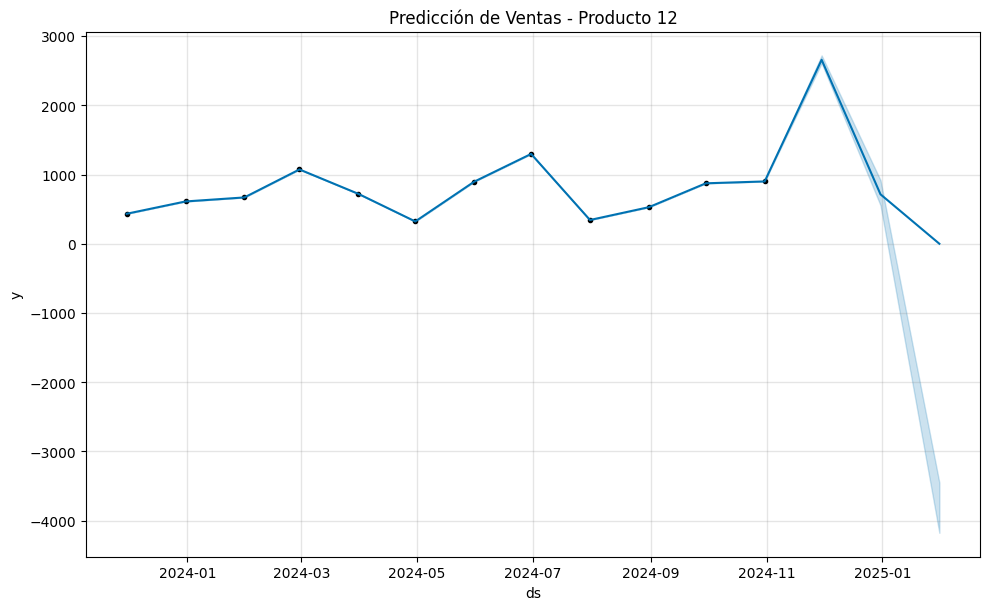


Producto 12 - Predicciones mensuales corregidas para los próximos 3 meses:
           ds         yhat
12 2024-11-30  2657.183630
13 2024-12-31   713.750196
14 2025-01-31     0.000000


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

for product in df['Product_ID'].unique():
    df_product = df[df['Product_ID'] == product][['Order_Date', 'Total_Sales']].rename(columns={'Order_Date': 'ds', 'Total_Sales': 'y'})

    # 🔹 Usar solo los últimos 12 meses de datos
    df_product = df_product[df_product['ds'] >= df_product['ds'].max() - pd.DateOffset(months=12)]

    # 🔹 Asegurar que los datos estén en formato mensual
    df_product = df_product.set_index('ds').resample('M').sum().reset_index()

    # 🔹 Crear y entrenar Prophet con mejoras
    model = Prophet(
        changepoint_prior_scale=1.0,  # Más flexibilidad en cambios de tendencia
        yearly_seasonality=True,
        seasonality_prior_scale=20
    )
    model.add_seasonality(name='monthly', period=30.5, fourier_order=20)  # Mejor estacionalidad
    model.fit(df_product)

    # 🔹 Generar fechas futuras en frecuencia mensual
    future = model.make_future_dataframe(periods=3, freq='M')

    # 🔹 Hacer predicciones
    forecast = model.predict(future)

    # 🔹 Asegurar que las predicciones sean siempre positivas
    forecast['yhat'] = forecast['yhat'].clip(lower=0)

    # 🔹 Graficar las predicciones
    fig = model.plot(forecast)
    plt.title(f'Predicción de Ventas - Producto {product}')
    plt.show()

    # 🔹 Mostrar solo las predicciones corregidas
    print(f"\nProducto {product} - Predicciones mensuales corregidas para los próximos 3 meses:")
    print(forecast[['ds', 'yhat']].tail(3))



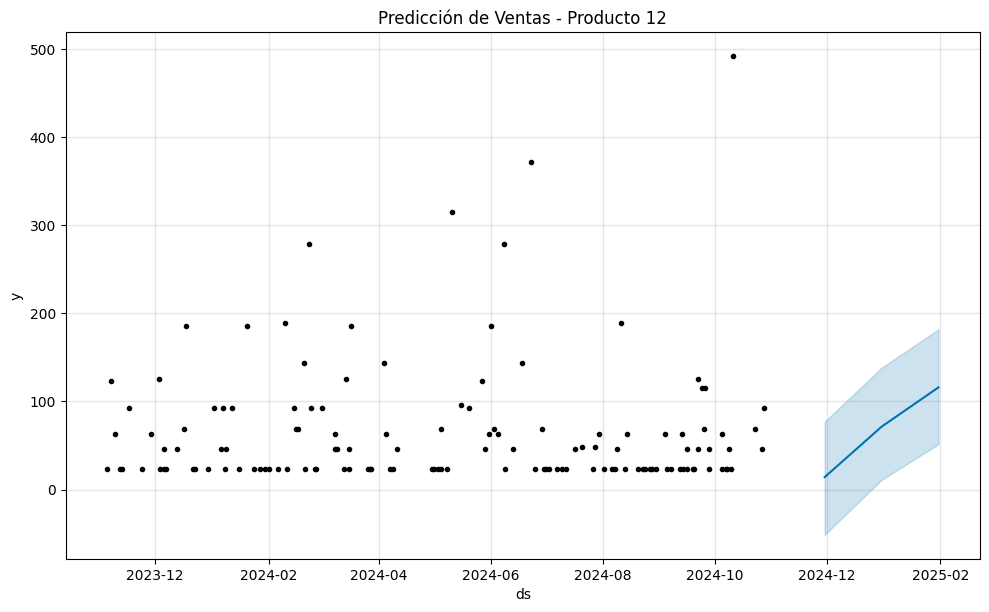

In [33]:
fig = model.plot(forecast)
plt.title(f'Predicción de Ventas - Producto {product}')
plt.show()

0    207.546476
1    210.904645
2    172.326559
Name: yhat_original, dtype: float64

In [7]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-11-05,1.441000,1.383356,1.667786,1.441000,1.441000,0.084058,0.084058,0.084058,-0.079409,...,0.036540,0.036540,0.036540,0.126927,0.126927,0.126927,0.0,0.0,0.0,1.525059
1,2023-11-07,1.442336,1.427658,1.708973,1.442336,1.442336,0.124597,0.124597,0.124597,-0.009490,...,0.003254,0.003254,0.003254,0.130833,0.130833,0.130833,0.0,0.0,0.0,1.566933
2,2023-11-09,1.443671,1.420057,1.697103,1.443671,1.443671,0.115780,0.115780,0.115780,-0.024437,...,0.011018,0.011018,0.011018,0.129199,0.129199,0.129199,0.0,0.0,0.0,1.559451
3,2023-11-12,1.445674,1.358224,1.653953,1.445674,1.445674,0.059294,0.059294,0.059294,-0.095877,...,0.036540,0.036540,0.036540,0.118631,0.118631,0.118631,0.0,0.0,0.0,1.504968
4,2023-11-13,1.446341,1.377400,1.661803,1.446341,1.446341,0.073768,0.073768,0.073768,0.026328,...,-0.066196,-0.066196,-0.066196,0.113636,0.113636,0.113636,0.0,0.0,0.0,1.520109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2024-10-27,1.679331,1.544005,1.829317,1.679331,1.679331,0.007598,0.007598,0.007598,-0.079216,...,0.036540,0.036540,0.036540,0.050273,0.050273,0.050273,0.0,0.0,0.0,1.686929
124,2024-10-28,1.679999,1.433040,1.714576,1.679999,1.679999,-0.104066,-0.104066,-0.104066,-0.101704,...,-0.066196,-0.066196,-0.066196,0.063834,0.063834,0.063834,0.0,0.0,0.0,1.575933
125,2024-10-31,1.682002,1.622661,1.921528,1.682002,1.682002,0.083450,0.083450,0.083450,-0.026143,...,0.011018,0.011018,0.011018,0.098575,0.098575,0.098575,0.0,0.0,0.0,1.765452
126,2024-11-30,1.702029,1.643967,1.942505,1.702029,1.702029,0.090705,0.090705,0.090705,-0.011800,...,0.014458,0.014458,0.014458,0.088048,0.088048,0.088048,0.0,0.0,0.0,1.792735


In [8]:
forecast[['ds', 'yhat']].iloc[-3:] 

,ds,yhat
125,2024-10-31,1.765452
126,2024-11-30,1.792735
127,2024-12-31,1.779003


In [9]:
mae_scores = {}
mape_scores = {}

for product in df['Product_ID'].unique():
    df_product = df[df['Product_ID'] == product][['Order_Date', 'Total_Sales']].rename(columns={'Order_Date': 'ds', 'Total_Sales': 'y'})

    # 🔹 Aplicar log1p para mayor estabilidad
    df_product['y'] = np.log1p(df_product['y'])

    # Crear y entrenar Prophet
    model = Prophet(
        changepoint_prior_scale=0.1,
        yearly_seasonality=True,
        seasonality_prior_scale=20
    )
    model.add_seasonality(name='monthly', period=30.5, fourier_order=10)
    model.fit(df_product)

    # 🔹 Generar fechas futuras para 3 meses adicionales
    future = model.make_future_dataframe(periods=3, freq='M')  # Agrega 3 meses al final

    # 🔹 Hacer predicciones
    forecast = model.predict(future)

    # 🔹 Extraer predicciones para los 3 meses futuros
    future_forecast = forecast[['ds', 'yhat']].iloc[-3:]  # Últimas 3 filas (futuro)

    # 🔹 Deshacer log1p
    future_forecast['yhat_original'] = np.expm1(future_forecast['yhat'])

    print(f"\nProducto {product} - Predicciones para los próximos 3 meses:")
    print(future_forecast)

    forecast_real = forecast[forecast['ds'].isin(df_product['ds'])]

    # Extraer valores reales y predicciones alineadas
    y_true = df_product['y'].values
    y_pred = forecast_real['yhat'].values  # Solo predicciones en fechas reales

    # Verificar tamaños nuevamente
    print(f"Tamaño de y_true (datos reales): {len(y_true)}")
    print(f"Tamaño de y_pred (predicciones alineadas): {len(y_pred)}")

    mae_log = mean_absolute_error(y_true, y_pred)
    mape_log = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100

    # 🔹 Deshacer log1p para evaluar en la escala original
    y_true_original = np.expm1(y_true)
    y_pred_original = np.expm1(y_pred)

    mae = mean_absolute_error(y_true_original, y_pred_original)
    mape = np.mean(np.abs((y_true_original - y_pred_original) / np.maximum(y_true_original, 1))) * 100

    mae_scores[product] = mae
    mape_scores[product] = mape

print("\nResumen de errores:")
for product in mae_scores.keys():
    print(f'Producto {product} → MAE: {mae_scores[product]:.2f}, MAPE: {mape_scores[product]:.2f}%')


09:20:33 - cmdstanpy - INFO - Chain [1] start processing
09:20:33 - cmdstanpy - INFO - Chain [1] done processing



Producto 0 - Predicciones para los próximos 3 meses:
            ds      yhat  yhat_original
319 2024-11-30  1.839685       5.294555
320 2024-12-31  1.842770       5.314004
321 2025-01-31  1.812165       5.123689
Tamaño de y_true (datos reales): 715
Tamaño de y_pred (predicciones alineadas): 319


ValueError: Found input variables with inconsistent numbers of samples: [715, 319]